In [1]:
import random
import torch
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [3]:
SEED = 42

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "../../data/ml-25m"

Device: cpu


## Data Acquisition

In [4]:
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

def get_movies_from_csv(nrows=None):
    path = "movies.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)
    print(data.head())
    return data

def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)

In [5]:
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"

In [6]:
ratings = get_ratings_from_csv()
movies = get_movies_from_csv()
print(ratings)

Loaded ml-25m data: ../../data/ml-25m/ratings.csv
Loaded ml-25m data: ../../data/ml-25m/movies.csv
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
          userId  movieId  rating
0              1      296     5.0
1              1      306     3.5
2              1      307     5.0
3              1      665     5.0
4              1      899     3.5
...          ...      ...     ...
25000090  162541    50872     4.5
25000091  162541    55768     2.5


In [7]:
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)

Loaded ml-25m data: ../../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 columns]


In [8]:
# films = get_data_from_csv(f"{root}/{ratings}")[]


# DATA VISUALIZATION


In [9]:
            # # Fill in missing values with zeros
            # X.fillna(0, inplace=True)


# FARE TEST CON AVG, STD_DEV

In [10]:
def addColumnOperation(ratings,X):
     # Compute the mean rating for each user
     count_rating = ratings.groupby('movieId', as_index=False)['rating'].count()
     std= ratings.groupby('movieId', as_index=False)['rating'].std()
     std.fillna(0, inplace=True)
     min_ratings= ratings.groupby('movieId', as_index=False)['rating'].min()
     max_ratings= ratings.groupby('movieId', as_index=False)['rating'].max()
     median= ratings.groupby('movieId', as_index=False)['rating'].median()
     operation = pd.DataFrame({'movieId':count_rating['movieId'],'count_rating': count_rating['rating'], 'std': std['rating'], 'min': min_ratings['rating'], 'max': max_ratings['rating'], 'median': median['rating']}) 
     X = pd.merge(X, operation, on='movieId')
     return X
    
def preprocessing1(relevance, ratings):
     # Reduce genome-score size
     # Pivot the relevance DataFrame to create a matrix of tag relevance scores for each movie
     relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
     counting = relevance.groupby('movieId', as_index=False)['relevance'].count()
     print(counting)
     # Merge the ratings and relevance data
     mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
     X = mean_ratings.merge(relevance_matrix, on='movieId')
     #X = addColumnOperation(ratings,X)
     X.columns = X.columns.astype(str)
     ratings = None  
     # mescolare le righe del DataFrame
     #X = X.sample(frac=1).reset_index(drop=True)
     
     y = X['rating']
     X.drop("movieId", axis=1, inplace=True)
     X = X.drop('rating', axis=1)
     return X,y

def preprocessing2(movies,relevance, ratings):
     # Merge the ratings and movies data
     #X = ratings.merge(movies, on='movieId')
     movies_genres = movies['genres'].str.split( '|')
     m = pd.get_dummies(movies_genres.apply(pd.Series).stack()).sum(level=0)
     movies_genres = pd.concat([movies['movieId'], m], axis=1)

     relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
     mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
     
     X = mean_ratings.merge(movies_genres, on='movieId')
     X = X.merge(relevance_matrix, on='movieId')
     X.columns = X.columns.astype(str)
     ratings = None  
     # mescolare le righe del DataFrame
     #X = X.sample(frac=1).reset_index(drop=True)
     
     y = X['rating']
     X.drop("movieId", axis=1, inplace=True)
     X = X.drop('rating', axis=1)
     
     # Apply PCA if n_components is specified
     pca = PCA()
     X = pca.fit_transform(X)
     return X,y

In [23]:
class LinearRegressionModel:
    def __init__(self, ratings,movies,relevance, seed=42):
        import matplotlib.pyplot as plt
        relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
        
        #Create One Hot Encoding for genres
        movies_genres = movies['genres'].str.split( '|')
        m = pd.get_dummies(movies_genres.apply(pd.Series).stack()).sum(level=0)
        movies_genres = pd.concat([movies['movieId'], m], axis=1)
        #print(movies_genres.columns)
        
        # Merge the ratings and relevance data
        mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
        X = mean_ratings.merge(relevance_matrix, on='movieId')
        X = X.merge(movies_genres, on='movieId')
        
        print(X.head)
        #X = addColumnOperation(ratings,X)
        X.columns = X.columns.astype(str)
        print(X.columns)
        
        ratings = None  

        # mescolare le righe del DataFrame
        #X = X.sample(frac=1).reset_index(drop=True)
        
        y = X['rating']
        X.drop("movieId", axis=1, inplace=True)
        X = X.drop('rating', axis=1)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        print(self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape)

        pca = PCA()
        pca.fit(self.X_train)
        self.X_train_t = pca.transform(self.X_train)
        self.X_test_t = pca.transform(self.X_test)
        #print(self.X_train)
        #print(self.X_train_t)
        plt.scatter(self.X_train_t[:, 0], self.X_train_t[:, 1], c=self.y_train, cmap='viridis')
        plt.show()
        
        plt.scatter(self.X_test_t[:, 0], self.X_test_t[:, 1], c=self.y_test, cmap='viridis')
        plt.show()
       
        self.model = LassoCV(n_jobs=-1, cv=3, verbose=2, random_state=seed)

    def train(self):
        # Fit the model to the training data
        #self.tuning(self.X_train, self.y_train)
        self.model.fit(self.X_train, self.y_train)
        print("Modello fittato senza PCA transformation")
        print(self.model.alpha_)
        self.test(self.X_test)
        self.model = LassoCV(n_jobs=-1, cv=3, verbose=2, random_state=SEED)
        #self.tuning(self.X_train_t, self.y_train)
        self.model.fit(self.X_train_t, self.y_train)
        print("Modello fittato con PCA transformation")
        print(self.model.alpha_)
        self.test(self.X_test_t)
    
     # Hyperparameter tuning
    def tuning(self,X,y):
        grid_search = GridSearchCV(self.model, param_grid=self.params, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best score: {grid_search.best_score_:.4f}")
        
        # Re-initialize the model with the best hyperparameters
        #self.model = LinearRegression(**grid_search.best_params_)


    def test(self, X_test):
        # Predict ratings for the test data
        y_pred = self.model.predict(X_test)

        # Compute the mean squared error
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2 = r2_score(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)

        print(f"MSE: {mse} RMSE: {rmse} R2: {r2} MAE: {mae}")
        score = self.model.score(X_test, self.y_test)
        print(f"Score:{score}")
        print("Intercept: "+str( self.model.intercept_))
        print("Coefficients: "+ str(self.model.coef_))


C:\Users\simon\AppData\Local\Temp\ipykernel_14708\1736311609.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  m = pd.get_dummies(movies_genres.apply(pd.Series).stack()).sum(level=0)


<bound method NDFrame.head of        movieId    rating        1        2        3        4        5  \
0            1  3.893708  0.02875  0.02375  0.06250  0.07575  0.14075   
1            2  3.251527  0.04125  0.04050  0.06275  0.08275  0.09100   
2            3  3.142028  0.04675  0.05550  0.02925  0.08700  0.04750   
3            4  2.853547  0.03425  0.03800  0.04050  0.03100  0.06500   
4            5  3.058434  0.04300  0.05325  0.03800  0.04100  0.05400   
...        ...       ...      ...      ...      ...      ...      ...   
13811   205072  3.310345  0.02050  0.01775  0.11400  0.03650  0.31225   
13812   205076  3.216981  0.03825  0.03150  0.03200  0.05325  0.20850   
13813   205383  3.642857  0.04100  0.04025  0.02750  0.07850  0.19750   
13814   205425  3.543478  0.04525  0.04125  0.04250  0.07425  0.11550   
13815   206499  3.055556  0.10050  0.09325  0.02225  0.04550  0.21125   

             6        7        8  ...  Film-Noir  Horror  IMAX  Musical  \
0      0.14675  0.

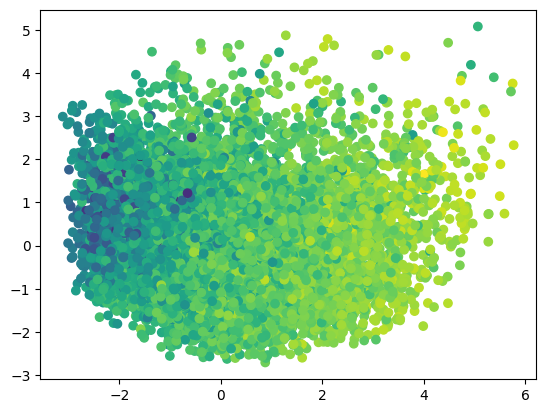

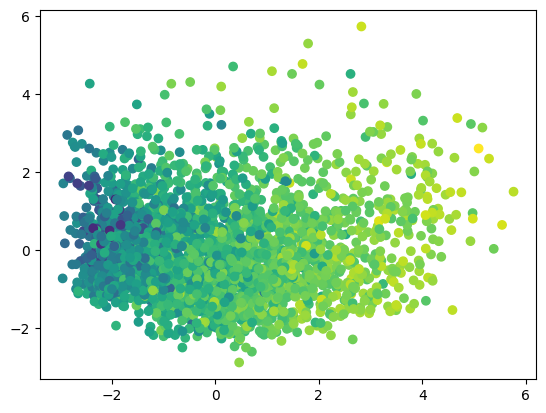

In [24]:
lr = LinearRegressionModel(ratings,movies,genome_scores, SEED)

In [25]:
lr.train()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Path: 000 out of 100
Path: 001 out of 100
Path: 000 out of 100
Path: 002 out of 100
Path: 001 out of 100
Path: 003 out of 100
Path: 000 out of 100
Path: 002 out of 100
Path: 004 out of 100
Path: 003 out of 100
Path: 001 out of 100
Path: 005 out of 100
Path: 004 out of 100
Path: 002 out of 100
Path: 006 out of 100
Path: 005 out of 100
Path: 003 out of 100
Path: 007 out of 100
Path: 006 out of 100
Path: 004 out of 100
Path: 008 out of 100
Path: 007 out of 100
Path: 005 out of 100
Path: 009 out of 100
Path: 008 out of 100
Path: 006 out of 100
Path: 010 out of 100
Path: 009 out of 100
Path: 007 out of 100
Path: 011 out of 100
Path: 010 out of 100
Path: 008 out of 100
Path: 012 out of 100
Path: 011 out of 100
Path: 009 out of 100
Path: 013 out of 100
Path: 012 out of 100
Path: 010 out of 100
Path: 014 out of 100
Path: 013 out of 100
Path: 011 out of 100
Path: 015 out of 100
Path: 014 out of 100
Path: 012 out of 100
Path: 016 out of 100
Path: 015 out of 100
Path: 013 out of 100
Path: 017 out

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished
C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.604e+01, tolerance: 2.624e-01
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Modello fittato senza PCA transformation
7.58057524586691e-05
MSE: 0.005437626616286971 RMSE: 0.07374026455259684 R2: 0.9754692902091618 MAE: 0.0568140400561933
Score:0.9754692902091618
Intercept: 3.5235673392658113
Coefficients: [-0.         -0.03598419 -0.         ...  0.00720282  0.00349004
  0.0052583 ]
Path: 000 out of 100
Path: 001 out of 100
Path: 000 out of 100
Path: 002 out of 100
Path: 000 out of 100
Path: 001 out of 100
Path: 003 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 004 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 005 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 006 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 007 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 008 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 009 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 010 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 011 out of 100
Path: 009 out of 100
Path: 010 out of 10

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Modello fittato con PCA transformation
0.0005771365197356646
MSE: 0.009354189909246451 RMSE: 0.0967170611073685 R2: 0.9578005379580845 MAE: 0.07365169438588465
Score:0.9578005379580845
Intercept: 3.268991462896886
Coefficients: [ 0.21850062 -0.04523108  0.11971282 ... -0.          0.
 -0.        ]


In [26]:
#lr.test()